In [29]:
import torch
import numpy as np
import pyquaternion
import glm
import os
import math
import matplotlib.pyplot as plt
import diff_gaussian_rasterization_batched as dgrb

In [30]:
device = torch.device("cuda")

# generate a random point cloud
C = 1
B = 1
N = 100
means3D = torch.cat(
    [
        torch.rand(B, N, 1, dtype=torch.float32, device=device) * 2 - 1,
        torch.rand(B, N, 1, dtype=torch.float32, device=device) * 2 - 1,
        torch.rand(B, N, 1, dtype=torch.float32, device=device) * 2 - 1,
    ],
    dim=2,
)
means2D = torch.zeros(B, N, 2, dtype=torch.float32, device=device)
opacities = torch.ones(B, N, 1, dtype=torch.float32, device=device)
scales = torch.ones(B, N, 3, dtype=torch.float32, device=device) * 0.1
rotations = (
    torch.from_numpy(np.stack([pyquaternion.Quaternion().elements for _ in range(N)]))
    .to(torch.float32)
    .to(device)
    .expand(B, N, 4)
)
colors_precomp = torch.rand(B, N, C, dtype=torch.float32, device=device)

In [31]:
def toTensor(m: glm.mat4) -> torch.Tensor:
    return torch.tensor(m.to_list(), dtype=torch.float32, device=device)

In [32]:
def random_point_on_sphere(r:float) -> list[float]:
    phi = torch.rand(1).item() * 2 * math.pi
    theta = torch.rand(1).item() * math.pi
    return [
            r * math.sin(theta) * math.cos(phi),
            r * math.sin(theta) * math.sin(phi),
            r * math.cos(theta),
    ]


[-1.8338282810911666, 2.1475405795397413, -1.012493602300937]


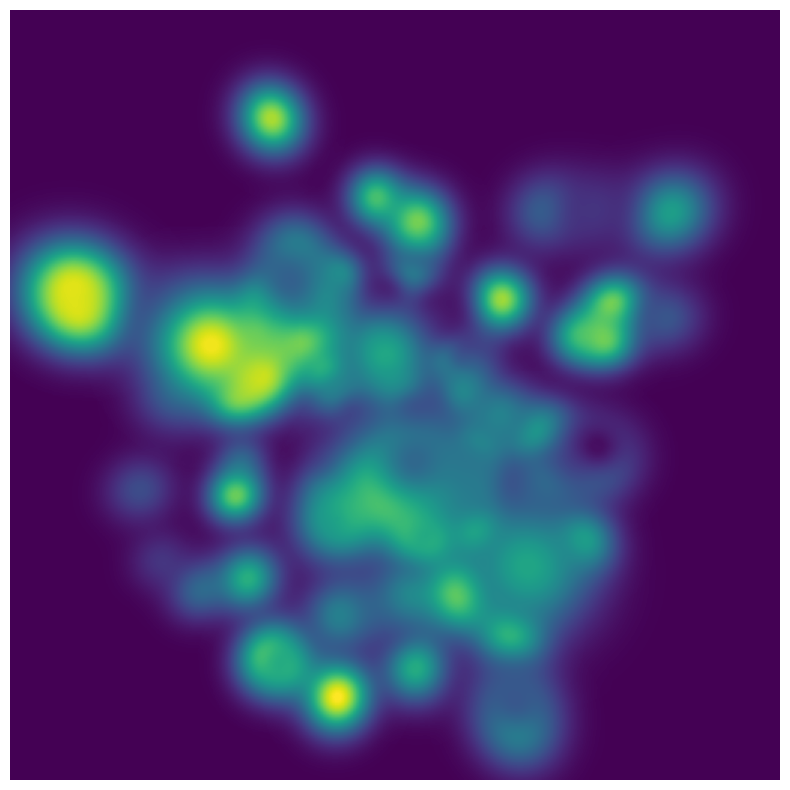

In [33]:
FoVx = math.radians(60)
FoVy = math.radians(60)


eye = random_point_on_sphere(3)
print(eye)


rasterizer = dgrb.GaussianRasterizer(
    dgrb.GaussianRasterizationSettings(
        image_channels=C,
        image_height=512,
        image_width=512,
        tanfovx=math.tan(FoVx * 0.5),
        tanfovy=math.tan(FoVy * 0.5),
        bg=torch.zeros(C, dtype=torch.float32, device=device),
        scale_modifier=1.0,
        viewmatrix=toTensor(
            glm.scale([1, 1, -1])
            * glm.lookAt(eye, [0, 0, 0], [0, 1, 0])
        ),
        projmatrix=toTensor(glm.perspective(FoVy, 1, 0.2, 100)),
        sh_degree=1,
        campos=torch.tensor([0, 0, 0], dtype=torch.float32, device=device),
        prefiltered=False,
        debug=True,
    )
)

rendered_image, radii = rasterizer(
    means3D=means3D,
    means2D=means2D,
    colors_precomp=colors_precomp,
    opacities=opacities,
    scales=scales,
    rotations=rotations,
)

# display the rendered image
image_batch = rendered_image.permute(0, 2, 3, 1).cpu().numpy()
batches = image_batch.shape[0]
fig, ax = plt.subplots(batches, 1, figsize=(10, 10), squeeze=False)
for i in range(batches):
    ax[i, 0].imshow(image_batch[i])
    ax[i, 0].axis("off")

In [34]:
means3D_homog = torch.cat([means3D, torch.ones(B, N, 1, dtype=torch.float32, device=device)], dim=2).squeeze(0)


view3D =  means3D_homog @ toTensor(glm.lookAt([0, 0, 0], [-2, 0, -2], [0, -1, 0])).T 
view3D_norm = view3D / view3D[:, 3].unsqueeze(1)

view3D_norm

tensor([[-3.1004e-01, -2.9925e-02,  7.8426e-01,  1.0000e+00],
        [ 6.8229e-01, -9.5434e-01, -5.7527e-01,  1.0000e+00],
        [ 1.1072e-01, -5.2164e-01, -8.8255e-01,  1.0000e+00],
        [-1.4294e-01,  7.9856e-01,  1.0687e+00,  1.0000e+00],
        [-5.2171e-01,  7.0743e-01,  1.5653e-01,  1.0000e+00],
        [-2.0735e-02, -8.9759e-02, -2.0621e-01,  1.0000e+00],
        [ 2.9897e-01, -5.2731e-01,  1.4713e-01,  1.0000e+00],
        [-5.4196e-01,  3.2147e-01,  4.2498e-01,  1.0000e+00],
        [-3.3482e-01, -6.4799e-01, -9.7135e-01,  1.0000e+00],
        [ 5.9689e-02, -7.4970e-01, -1.3277e+00,  1.0000e+00],
        [ 4.5328e-02,  9.3482e-01, -6.0853e-01,  1.0000e+00],
        [ 3.8977e-01,  1.2913e-01,  5.6245e-01,  1.0000e+00],
        [ 7.0580e-01,  1.9245e-01,  4.2549e-01,  1.0000e+00],
        [-1.1314e+00, -3.5518e-01, -2.1528e-01,  1.0000e+00],
        [ 7.9469e-02,  6.9852e-01,  1.2387e+00,  1.0000e+00],
        [-1.8530e-01, -4.1758e-01,  9.8713e-01,  1.0000e+00],
        